In [1]:
from igraph import *
import cairo

In [10]:
g = Graph.GRG(10, 0.5)

In [5]:
g = Graph.Tree(10, 3)

In [6]:
print(g.summary())

IGRAPH U--- 10 9 -- 


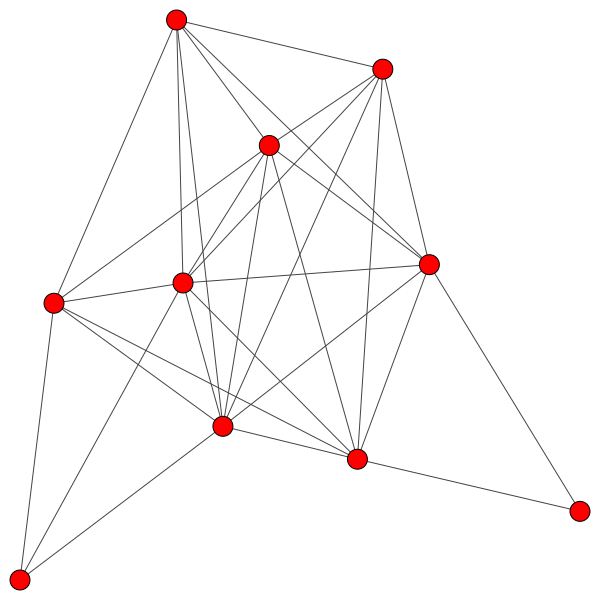

In [11]:
layout = g.layout("kk")
plot(g, layout = layout)

In [19]:
g.get_adjacency().shape
print(list(map(lambda x: x.degree(), g.vs)))

[2, 7, 7, 8, 7, 8, 6, 3, 6, 6]
